In [1]:
#Preamble
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib import colors
from multiprocessing import Pool
from multiprocessing import cpu_count
import time
import copy
import pickle
import emcee
import corner
import os

os.environ["OMP_NUM_THREADS"] = "1"

In [2]:
def generateEllipse(a,b,centerX,centerY, grid, opacity):
    for x in range(len(grid)):
        for y in range(len(grid[0])):
            if a > 0 and b > 0:
                if ((x-centerX)/a)*((x-centerX)/a) + ((y-centerY)/b)*((y-centerY)/b) <= 1:
                    grid[x][y] = opacity
    
    return grid

In [3]:
def transitSim(a,b,r, speed, times, tref, opacity):
    ab = a/b
    br = b/r
    
    tmin = tref - 1/(2*speed)
    tmax = tref + 1/(2*speed)
    transitTimes = [t for t in times if t >= tmin and t <= tmax]
    flux = [1 for t in times if t < tmin]
    differences = []
    for i in range(1,len(transitTimes)):
        differences.append(transitTimes[i] - transitTimes[i-1])
    
    minDiff = np.min(differences)
    intDiffs = [int(d/minDiff) for d in differences]
    length = np.sum(intDiffs)
    
    
    res = int((2*(b+r))/length)
    if res < 1:
        res = 1
    rnew = int(res*length/(2*(1+br)))
    bnew = int(br*rnew)
    anew = int(ab*bnew)
    newIntDiffs = [res*i for i in intDiffs]
    
    starGrid = np.zeros([2*rnew, 4*bnew+2*rnew+4])
    ellipseGrid = np.zeros([2*rnew, 4*bnew+2*rnew+4])
    starGrid = generateEllipse(rnew,rnew,rnew, 2*bnew+rnew, starGrid,1)
    ellipseGrid = generateEllipse(anew,bnew,rnew,3*bnew+2*rnew + 2,ellipseGrid,opacity)
    planetGrid = np.ones([2*rnew,4*bnew+2*rnew+ 4]) - ellipseGrid
    fluxGrid = np.multiply(starGrid,planetGrid)
    initialFlux = np.sum(fluxGrid)
    
    for i in newIntDiffs:
        for j in range(i):
            planetGrid = np.delete(planetGrid,0,1)
            planetGrid = np.append(planetGrid,np.ones([2*rnew,1]),1)
            
        
        fluxGrid = np.multiply(starGrid,planetGrid)
        percentFlux = np.sum(fluxGrid)/initialFlux
        flux.append(percentFlux)
        
    for t in times:
        if t > tmax:
            flux.append(1)
    
    flux.append(1)
    return flux

In [4]:
def logLikelihood(theta, times, flux, fluxErr):
    """
    Calculates the log likelihood based on the difference between the model and the data
    
    Args:
        theta (list) - parameters of the model
        times (list) - time array of the light curve
        flux (list) - array of flux data points
        fluxErr (list) - array of errors for the flux data points
    
    Returns:
        lnl (float) - log likelihood for the given theta values
    """
    xdim, ydim, velocity, tRef, opacity = theta
    fluxPredicted = transitSim(xdim, ydim,50,velocity,times, tRef,opacity)
    error = [((flux[i] - fluxPredicted[i])**2) /(2*fluxErr[i]**2) for i in range(len(flux))]
    lnl = -np.sum(error)
    return lnl

In [5]:
def logPrior(theta, times):
    """
    Returns flat priors, checking that the given theta values are physically possible
    
    Args:
        theta (list) - parameters of the model
        times (list) time array of the light curve
        
    Returns: 
        lnPrior (float) - fixed log prior value if theta values are allowed, -inf if theta values aren't
    """
    xdim, ydim, velocity, tRef, opacity = theta
    lnPrior = 0
    if times[0] < tRef < times[-1]:##Check to see if center of transit is within the bounds of the light curve
        lnPrior += np.log(1/(times[-1]-times[0]))
    else:
        return -np.inf
    if 0 < xdim < 40 and 0 < ydim < 30 and 0 < velocity < 50 and 0 < opacity < 1: ##Check to see if the shape exists but is not larger than the star
        ##Also check to see that it transits in a consistent direction and not extremely fast
        lnPrior +=  2*np.log(1/100) + np.log(1/50) + np.log(1)
    else:
        return -np.inf
    return lnPrior

In [6]:
def logProbability(theta, times, flux, fluxErr):
    """
    Combines the log likelihood and log prior to get log probability
    
    Args:
        theta (list) - parameters of the model
        times (list)
    """
    startTime = time.time()
    lp = logPrior(theta, times)
    if not np.isfinite(lp):
        return -np.inf
    ll = logLikelihood(theta, times, flux, fluxErr)
    endTime = time.time()
    #print(endTime - startTime)
    return (lp + ll)

In [7]:
def getData(filename): 
    """
    Reads the necessary data from the elanor pipeline TESS lightcurve pickle files
    
    Args:
        filename (string) - name of the pickle file excluding the .pkl extension
        
    Returns:
        times (list) - list of times of observations in moditied julian day
        flux (list) - list of normalized flux values
        err (list) - list of error for the flux values
    """
    fp = open("./"+filename+".pkl","rb") 
    data = pickle.load(fp)##Unpickles the file
    fp.close()
    
    q = data[11]==0 ##Get the locations of high quality data
    times = data[6][q]##Take only high quality data
    flux = data[9][q]
    maxFlux = np.median(flux)
    flux /= maxFlux ##Normalize flux
    err = np.ones_like(flux)*np.nanstd(np.diff(flux))##Calculate error
    err /= np.sqrt(2)
    return times, flux, err

In [ ]:
times, flux, _ = getData("lcs/tesslc_400799224")
fig = plt.subplot()
fig.plot(times, flux)
plt.show()

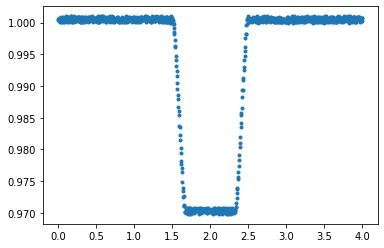

8 CPUs


In [8]:
times = np.linspace(0,4,1000)
flux = transitSim(10,10,50,1,times,2,0.8)
fluxErr = 0.001*np.ones(1000)
flux = flux + np.random.random(1000)*fluxErr
fig = plt.subplot()
fig.plot(times, flux, ls = '', marker = '.')
plt.show()

ncpu = cpu_count()
print("{0} CPUs".format(ncpu))

In [23]:
pos = [10,10,1,2,1] * np.ones([16,5]) + np.random.random([16,5]) - 0.5
nwalkers, ndim = pos.shape

with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, logProbability, args = (times, flux, fluxErr), pool = pool)
    sampler.run_mcmc(pos,6000, progress = True)

  0%|                                                                                               | 0/6000 [00:00<?, ?it/s]/home/jbromley/.local/lib/python3.7/site-packages/emcee/moves/red_blue.py:97: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|████████████████████████████████████████████████████████████████████████████████████| 6000/6000 [30:00<00:00,  3.33it/s]


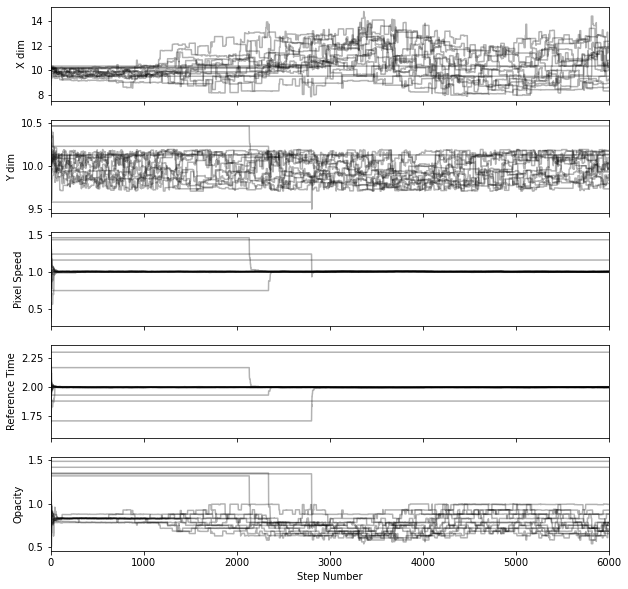

In [24]:
##This block plots the traces of the 4 parameters
fig, axes = plt.subplots(5,figsize = (10,10), sharex = True)
samples = sampler.get_chain()
labels = ["X dim", "Y dim", "Pixel Speed", "Reference Time", "Opacity"]
for i in range(ndim):
    axes[i].plot(samples[:,:,i],'k',alpha = 0.3)
    axes[i].set_xlim(0,len(samples))
    axes[i].set_ylabel(labels[i])
    
axes[-1].set_xlabel("Step Number")
plt.show()

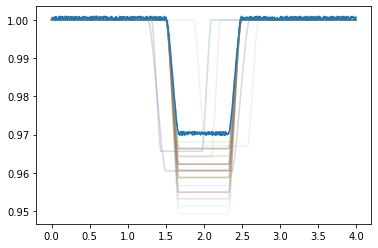

In [28]:
fig = plt.subplot()
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
inds = np.random.randint(len(flat_samples), size=50)
for ind in inds:
    sample = flat_samples[ind]
    sampleFlux = transitSim(sample[0],sample[1],50,sample[2],times,sample[3],1)
    fig.plot(times,sampleFlux,alpha = 0.1)
    
    
fig.plot(times,flux)
plt.show()
    

In [26]:
tau = sampler.get_autocorr_time()
print(tau)

/home/jbromley/.local/lib/python3.7/site-packages/emcee/autocorr.py:38: RuntimeWarning: invalid value encountered in true_divide
  acf /= acf[0]


AutocorrError: The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 120;
tau: [         nan          nan          nan 811.37674001 806.21047544]